# Importing the necessary modules

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('dataset/output/merged_data.csv')

## We count the news per category

In [3]:
df[["text","class"]].groupby("class").count()

,text
class,
Culture & Literature,311
Economics,1213
Education,85
Health,31
Leisure,1000
Politics & Society,1482
Technology & Innovation,445
World & Migration,323


## Bar plot of above frequency of text file per category

<Axes: xlabel='class'>

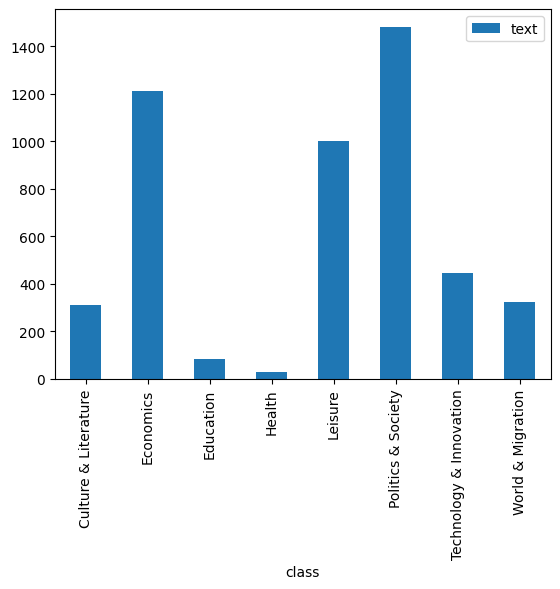

In [4]:
df[["text","class"]].groupby("class").count().plot(kind="bar")

# Load our Stopwords file

In [5]:
stop_file = "nepali_stopwords.txt"
stop_words = []
with open(stop_file, encoding='utf-8') as fp:
    lines = fp.readlines()
    stop_words =list( map(lambda x:x.strip(), lines))
stop_words

[]

# Load our Punctuation word file

In [6]:
punctuation_file = "nepali_punctuation.txt"
punctuation_words = []
with open(punctuation_file, encoding='utf-8') as fp:
    lines = fp.readlines()
    punctuation_words =list( map(lambda x:x.strip(), lines))
punctuation_words

[]

# Text pre-processing
### Here er wrote a method called preprocess_text that takes data, stop words, and punctuation words as parameters. Then, we created a list called new_cat to hold it. Also initialized noise as numbers. For each words:
   *  #### If word is not in punctuation or stop words then,
   *  #### Do not take this word if it contains noise characters.
   *  #### Remove parenthesis

In [7]:
from snowballstemmer import NepaliStemmer

def preprocess_text(cat_data, stop_words, punctuation_words):
    stemmer = NepaliStemmer()
  
    new_cat = []
    noise = "1,2,3,4,5,6,7,8,9,0,०,१,२,३,४,५,६,७,८,९".split(",")
  
    for row in cat_data:
        words = row.strip().split(" ")      
        nwords = ""
    
        for word in words:
            # apply Nepali stemming to the word
            if word not in punctuation_words and word not in stop_words:
                word = stemmer.stemWord(word)
                
                is_noise = False
                for n in noise:
                    if n in word:
                        is_noise = True
                        break
                if not is_noise and len(word) > 1:
                    word = word.replace("(","")
                    word = word.replace(")","")
                    nwords += word + " "
                
          
        new_cat.append(nwords.strip())
  
    return new_cat

title_clean = preprocess_text(["\nसगरमाथा चुचुरोमा पुग्ने ९ शेर्पा टोलीको नेतृत्व लेख्नु चाहनुहुन्छ गरेको छ ।"], stop_words, punctuation_words)
print(title_clean)

['सगरमाथा चुचुरो पुग् शेर्पा टोली नेतृत्व लेख् चाह गर']


# Importing the necessary module for Multinomial Naive Bayes

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer

# Splitting data into Train and Test set
  ### Here we are splitting the Train data as 80% and Test data as 20%. Train data are used for model fitting and test data are used while doing model prediction. But before that, we     will merge two similar categories into one and also assign a unique label for each class.

In [9]:
data = pd.DataFrame()

data["text"]=df.text
# Preprocess the text data
data["text"] = preprocess_text(data["text"], stop_words, punctuation_words)


# data["category"]=ndf.category

data["label"]=df['class']
data["target"] = data["label"]
classes = {c:i for i,c in enumerate(data.target.unique())}
data["target"] = data.target.apply(lambda x: classes[x])

print(classes)


{'Technology & Innovation': 0, 'Economics': 1, 'Culture & Literature': 2, 'Education': 3, 'Leisure': 4, 'Health': 5, 'Politics & Society': 6, 'World & Migration': 7}


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(
    data["text"], data["target"], test_size=0.2, random_state=1)

vectorizer = CountVectorizer(ngram_range=(1, 2)).fit(X_train)
X_train_vectorized = vectorizer.transform(X_train)

In [11]:
tfidf_transformer=TfidfTransformer()
X_train_tfidf=tfidf_transformer.fit_transform(X_train_vectorized)
X_train_tfidf.shape

(3912, 218624)

# Model Fitting 

In [ ]:
import numpy as np
from scipy.sparse import csr_matrix

class Multinomial:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_prior = None
        self.feature_log_prob = None
        self.classes = None
        
    def fit(self, X, y):
        # X is expected to be already vectorized (sparse matrix format)
        # Get unique class labels and their counts
        self.classes, class_counts = np.unique(y, return_counts=True)
        n_classes = len(self.classes)
        
        # Calculate class prior probabilities
        self.class_prior = class_counts / np.sum(class_counts)
        
        # Calculate count of each feature per class and add smoothing
        feature_count = np.zeros((n_classes, X.shape[1]))
        for i in range(n_classes):
            Xi = X[y == self.classes[i]]
            feature_count[i, :] = np.array(Xi.sum(axis=0)).flatten() + self.alpha
        
        # Calculate count of each class
        class_count = feature_count.sum(axis=1)
        
        # Calculate log probability of each feature for each class
        self.feature_log_prob = (np.log(feature_count) - np.log(class_count.reshape(-1, 1)))
        
        return self
    
    def _log_prob(self, X):
        # Calculate log probability of each class for each sample
        return X @ self.feature_log_prob.T + np.log(self.class_prior)
    
    def predict(self, X):
        # Calculate log probability of each class for each sample
        log_prob = self._log_prob(X)
        
        # Find class with highest log probability for each sample
        y_pred = np.argmax(log_prob, axis=1)
        
        # Map class index to label
        return self.classes[y_pred]
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)  # Return accuracy



In [24]:
model = MultinomialNB(alpha=0.08)
# model = Multinomial(alpha=0.08)
model.fit(X_train_vectorized, Y_train)
model.score(X_train_vectorized, Y_train)

0.9552658486707567

# Accuracy

In [25]:
predictions = model.predict(vectorizer.transform(X_test))
print("Accuracy:", 100 * sum(predictions == Y_test) / len(predictions), '%')

Accuracy: 69.01840490797547 %


In [15]:
x_train_transformed = vectorizer.transform(X_test)

In [16]:
y_predicted = model.predict(x_train_transformed)

# Calculating the precison, recall and f1 score of out Test data set

In [17]:
PRECISION_SCORE = precision_score(Y_test, y_predicted, average='weighted')
RECALL_SCORE = recall_score(Y_test, y_predicted, average='weighted')
F1_SCORE = f1_score(Y_test, y_predicted, average='weighted')
print("PRECISION_SCORE :" ,PRECISION_SCORE)
print("RECALL_SCORE :" ,RECALL_SCORE)
print("F1_SCORE :" ,F1_SCORE)

PRECISION_SCORE : 0.7061501665499601
RECALL_SCORE : 0.6860940695296524
F1_SCORE : 0.6788232332639001


# Confusion Matrix

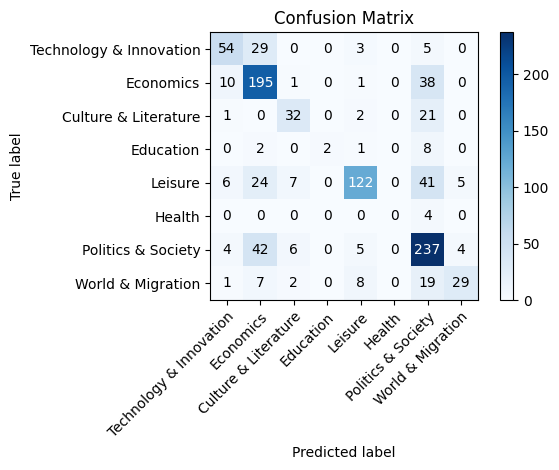

In [18]:
# visualize confusion matrix
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

plot_confusion_matrix(Y_test, y_predicted, classes)

# Creating the unique class for different category

In [19]:
print(classes)

{'Technology & Innovation': 0, 'Economics': 1, 'Culture & Literature': 2, 'Education': 3, 'Leisure': 4, 'Health': 5, 'Politics & Society': 6, 'World & Migration': 7}


# Finally we predict our untrained data and try to find the right category

In [20]:
prd = model.predict(vectorizer.transform([
        """
काठमाडौँ — नेपाली यू–१९ महिला क्रिकेट टोलीले आईसीसी यू–१९ महिला ट्वान्टी–२० विश्वकपको एसिया छनोटमा तेस्रो जित हात पारेको छ । नेपालले यूएईमा भइरहेको प्रतियोगितामा आइतबार थाइल्यान्डलाई १ सय ६ रनले पराजित गर्‍यो ।

ओपनर साना प्रवीणको अर्धशतकपछि टस जितेको नेपाल अजमानस्थित द सेभेन रंगशालामा पूरा २० ओभर खेली १ सय ३९ रनमा अलआउट भएको थियो । प्रवीणले ४६ बल खेली ७ चौकासहित ५३ रन जोडिन् । उनले सावित्री धामीसँग पहिलो विकेटमा १३ ओभरमा ८८ रन जोडेकी थिइन् । सावित्रीले ३६ बल खेली १ चौकासहित २८ रन बनाइन् ।


कप्तान पूजा महतो ४, सोनी पाख्रिन १० बलमा ३ चौका प्रहार गरी १९, ज्यात्सनिका मरासिनी ७, एलिसाकुमारी यादव १ र रचनाकुमारी चौधरी ५ रनमा आउट भइन् । तृष्णा विश्वकर्माले अविजित ९ रन बनाएको नेपाली इनिङ्समा सीमा केसी र कुसुम गोदारले खाता खोल्न सकेनन् । थाइल्यान्डकी नाथारिका थोकोईले ३ र केसिनी काइवजुम्फोलले २ विकेट लिए ।

जवाफमा आएको थाइल्यान्ड १६ ओभरमा ३३ रनमा अलआउट भयो । टोलीबाट कसैले दोहोरो स्कोर बनाउन सकेनन् । नेपालबाट कुसुमले ३ विकेट लिइन् । उनले ४ ओभरमा १ मेडन राख्दै ९ रन खर्चेकी थिइन् । रिया शर्मा र रचनाले २–२ तथा पूजाले १ विकेट लिइन् ।

नेपालले चौथो खेलमा तेस्रो जित हात पारेको हो । अघिल्लो दिन थाइल्यान्डसँग नेपाल १३ रनले पराजित भएको थियो । यूएईले पहिलो चार खेल नै जितेको छ । यूएईले आइतबार नै भएको खेलमा कुवेतलाई १ सय ८४ रनले पराजित गरेको थियो ।
"""
]))

print(prd)


nprd = []



for k, v in classes.items():
    for p in prd:
        if v == p:
            nprd.append(k)

nprd

[4]


['Leisure']

In [21]:
import pickle

In [22]:
filename = 'news_pred_model.pickle'
pickle.dump(model, open(filename, 'wb'))

In [23]:
filename = 'news_pred_vectorizer.pickle'
pickle.dump(vectorizer, open(filename, 'wb'))